In [7]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
config_path='config/yolov3.cfg'
weights_path='weights/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.to(device)
model.eval()
classes = utils.load_classes(class_path)

/Users/vivianwong/anaconda3/envs/pedtrack/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [18]:
# Video 00084.wmv specific
videopath = 'data/00084.wmv'
resultpath_detection = 'results/00084.avi'
resultpath_world = 'results/00084_2D.avi'

assumed_height = 174
pts_img = [[450.0,203.0],[282.0,297.0],[470.0,403.0],[630.0,270.0]] # top left, bot left, bot right, top right 
pts_world = [[250,250], [250,500], [500,500],[500,250]]

h, status = cv2.findHomography(np.array(pts_img), np.array(pts_world)+700)

#### converting any coordinate to world coordinate 
def img_to_world_coords(coords_img, pts_img, pts_world):
    '''
    use at least 4 
    input: 
        coords_img: a np array of dim (num_ped,seq_len,2)
        pts_img: a list of [x,y] points in image coordinates. list length cannot be shorter than 4
        pts_world: a list of [x,y] points in world coordinates. each point cooresponds to a point in pts_img
        assumed_height: the estimated height of all humans. source: https://www.sciencedirect.com/science/article/pii/S0379073811002167
                        NOT USED FOR NOW 
    output: 
        coords_world: same shape as coords_img but in world coordinates
    '''
    # convert to np matrix and check size

    pts_img = np.array(pts_img)
    pts_world = np.array(pts_world)+700 # the 700 offset is for 0084.wmv only. 
    assert pts_img.shape==pts_world.shape and pts_img.shape[0] >= 4
     
    # calculate homography matrix H. more pts_img means more accurate H
    h, status = cv2.findHomography(pts_img, pts_world)
     
    # finally, get the mapped world coordinates
    coords_world = cv2.perspectiveTransform(coords_img.astype(numpy. float32), h)
    # coords_world[:,1] += assumed_height
    return coords_world

In [13]:
def calc_num_violated (all_pedestrians):
    num_violated = 0
    
    for p in all_pedestrians: 
        min_y = 100000
        if p.y2 < min_y: 
            min_y = p.y2
            closest_p = p

    radius_cm = closest_p.box_w * assumed_height / closest_p.box_h / 2
    worlddist2cm = radius_cm / closest_p.radius 
    from itertools import combinations 

    for (p1,p2) in combinations(all_pedestrians, 2): 
        if p1.is_violating_sd(p2, worlddist2cm):
            assert p2.is_violating_sd(p1, worlddist2cm)
            p1.is_violating=True
            p2.is_violating=True
    
    for p in all_pedestrians: 
        if p.is_violating:
            num_violated += 1
            
    return num_violated

def draw_circle(frame, center, radius, color=None): 
    cv2.circle(frame, (int(center[0]), int(center[1])), int(radius), color=color, thickness=10)

def draw_point(frame, center): 
    draw_circle(frame, center, 1, color=(0,255,0))

def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(torch.FloatTensor).to(device))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

# custom pedestrian class 
class Pedestrian:
    def __init__(self, coords1, coords2, pedestrian_id, cls, box_h, box_w):
        self.x1, self.y1 = coords1 # top lef
        self.x2, self.y2 = coords2 # bot right 
        self.id = pedestrian_id # in this frame 
        self.cls = cls # either 'person' or 'bicycle'
        self.box_h = box_h
        self.box_w = box_w 

        feet = img_to_world_coords(np.array([[[self.x1, self.y2],[self.x2,self.y2]]]), pts_img, pts_world).squeeze()
        feetL = feet[0,:]
        feetR = feet[1,:]
        
        self.radius = np.linalg.norm(feetL - feetR)/2 
        
        center_x =(feetL[0] + feetR[0])/2
        center_y = (feetL[1] + feetR[1])/2
        self.center = np.array([center_x, center_y])
        self.is_violating = False
        
    def is_violating_sd(self, ped2, worlddist2cm, threshold=182.88): # threshold = 100 cm according to WHO  
        '''
        return true if self and ped2 are too close
        '''
        distance = np.linalg.norm(ped2.center - self.center) - ped2.radius - self.radius
        distance *= worlddist2cm 
        if distance < threshold: 
            return True
        else: 
            return False 

Populating the interactive namespace from numpy and matplotlib


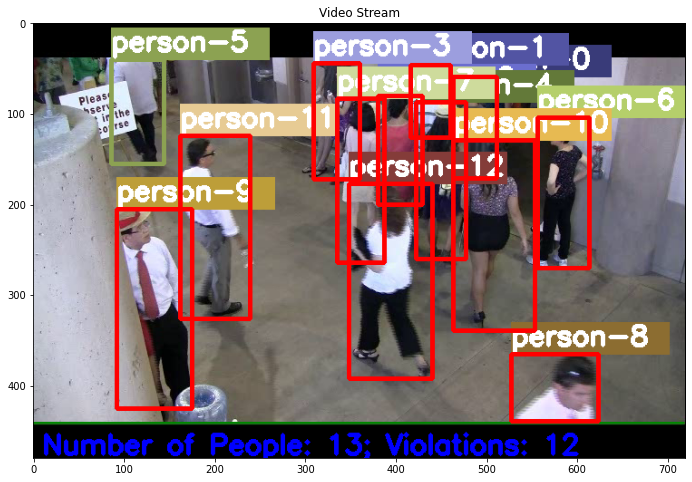

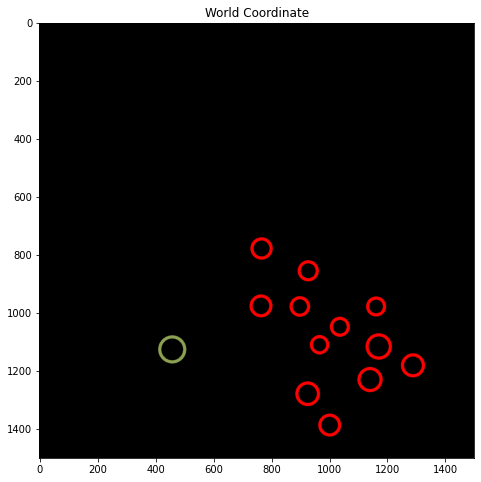

In [42]:
%pylab inline 
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
fps = int(vid.get(cv2.CAP_PROP_FPS))
width  = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
mot_tracker = Sort() 

# result1 = cv2.VideoWriter(resultpath_detection, 
#                 cv2.VideoWriter_fourcc(*'MJPG'),
#                 fps, 
#                 (width, height))
# result2 = cv2.VideoWriter(resultpath_world, 
#                 cv2.VideoWriter_fourcc(*'MJPG'),
#                 fps, 
#                 (1500, 1500))
# while(True):
for ii in range(1): # just do this many number of frames for now 
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    ########### vivian initialize ############
    pedestrian_id = 0
    all_pedestrians = [] # all of the people in this frame 
    ##########################################
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

#             color = colors[int(obj_id) % len(colors)]
#             color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            if cls == 'person' or cls == 'bicycle': # 0: person, 1: bicycle
                color = colors[int(pedestrian_id) % len(colors)]
                color = [i * 255 for i in color]
                cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
                cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
                cv2.putText(frame, cls + "-" + str(pedestrian_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
                # vivian added
                all_pedestrians.append(Pedestrian((x1, y1), (x1+box_w, y1+box_h), pedestrian_id, cls, box_h, box_w))
                pedestrian_id += 1
    
    #### plotting and showing social distancing violations in video frames ####
    # social distancing 
    num_violated = calc_num_violated (all_pedestrians)
    cv2.putText(frame, "Number of People: "+str(len(all_pedestrians))+"; Violations: "+str(num_violated), (10,frame.shape[0]-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)
    
    # show 2D transformed world coordinates
    warped_frame = cv2.warpPerspective(frame, h, dsize=(1500,1500))
    warped_frame *= 0 # make all black 
    for p in all_pedestrians:
        color = colors[int(p.id) % len(colors)]
        color = [i * 255 for i in color]
        draw_circle(warped_frame, p.center, p.radius, color)
        # overlap red color if violated 
        if p.is_violating: 
            color = (255,0,0)
            cv2.rectangle(frame, (p.x1, p.y1), (p.x2, p.y2), color, 4)
            draw_circle(warped_frame, p.center, p.radius, color)
            
            
        
    ####### show videos in jupyter notebook inline #######
    fig1=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    
    fig2=figure(figsize=(12,8))
    title("World Coordinate")
    imshow(warped_frame)
    ########save video to results folder###############
#     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#     result1.write(frame)
#     warped_frame = cv2.cvtColor(warped_frame, cv2.COLOR_RGB2BGR)
#     result2.write(warped_frame)
    #################################################
    show()
    clear_output(wait=True)

In [38]:
vid.release()
result1.release()
result2.release()

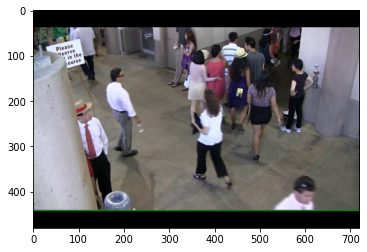

In [40]:

vid = cv2.VideoCapture(videopath)
ret, frame = vid.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
imshow(frame)